# Information Value

Vamos a testear Information Value definido por Zanette & Montemurro.

La primer versión que veremos es sobre un texto shuffleado. Esta es la que, en teoría, anda bien (o al menos da los mismos resultados que el paper!).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from __future__ import division, print_function
import pandas as pd
import numpy as np
import nltk
import math
from nltk.corpus import stopwords, gutenberg 
from iv_helpers import get_moby_dick_tokens

md_tokens = get_moby_dick_tokens()

fd = nltk.FreqDist(md_tokens)

In [2]:
from scipy.stats import entropy

window_size = 5000

def ocurrence_dataframe(tokenized_text, window_size):
    """
    Construye una matriz de ocurrencias dado un tamaño de ventana
    """
    freq = {}
    """
    N = Largo del texto
    P = Cantidad de ventanas
    """
    N = len(tokenized_text)
    P = int(math.ceil(N / window_size))

    for i in range(0, P):
        """
        Para cada ventana: hago un Fdist de la ventana, y lo sumo a las palabras que ya tenga
        """
        lower_bound, upper_bound = window_size * i, min(window_size* (i+1), N) 
        window = tokenized_text[lower_bound:upper_bound]
        window_fdist = nltk.FreqDist(window)

        for word in window_fdist:
            if word not in freq:
                freq[word] = [0] * P
                
            freq[word][i] = window_fdist[word]
            
    df = pd.DataFrame.from_dict(freq, orient="index")
    
    df["entropy"] = df.apply(entropy, axis=1, raw=True)
    df["total"] = df[range(P)].apply(sum, axis=1, raw=True)
    df["freq"] = df["total"] / len(tokenized_text)
    df["not_stop_word"] = df.index.map(lambda w: w not in stopwords.words('english'))
    
    return df

occurrence_df = ocurrence_dataframe(md_tokens, window_size)

occurrence_df.sort_values(by="entropy", inplace=True)

# Information Value

Calculemos Information Value con un texto randomizado

In [16]:
import random

# Shuffleo Texto
shuffled_text = random.shuffle(md_tokens)
shuffled_df = ocurrence_dataframe(md_tokens, window_size)
#
occurrence_df["shuffled_entropy"] = shuffled_df["entropy"]
occurrence_df["information_value"] = occurrence_df.freq * (occurrence_df.shuffled_entropy - occurrence_df.entropy)

occurrence_df.sort_values("information_value", ascending=False, inplace=True)
occurrence_df.iloc[:40][occurrence_df.columns.difference(range(42))]

,entropy,freq,information_value,not_stop_word,shuffled_entropy,total
whale,3.437954,0.005854,0.001674,True,3.723861,1226
ahab,3.129364,0.002440,0.001394,True,3.700753,511
queequeg,2.680595,0.001203,0.001146,True,3.632623,252
is,3.592272,0.008237,0.001107,False,3.726734,1725
ye,3.230246,0.002254,0.001076,True,3.707771,472
you,3.480810,0.004269,0.001007,False,3.716699,894
thou,2.934329,0.001294,0.000987,True,3.696919,271
me,3.403535,0.003022,0.000894,False,3.699171,633
stubb,2.959690,0.001227,0.000865,True,3.664365,257
jonah,1.433252,0.000406,0.000851,True,3.530034,85


In [5]:
import random

def random_balls_in_bins(balls, bins):
    """
    Returns a list of <bins> integers that sum <balls>
    """
    balls_and_bins = list('o' * balls + '|' * (bins-1))
    random.shuffle(balls_and_bins)

    urns = []
    current_urn = 0
    
    for e in balls_and_bins:
        if e == 'o':
            current_urn +=1
        elif e == '|':
            urns.append(current_urn)
            current_urn = 0

    urns.append(current_urn)
    
    return urns


In [8]:
random_balls_in_bins(balls=10, bins=20)

[2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 4, 0, 1]

In [14]:


def simulated_shuffled_entropy(word_series, no_tokens, window_size):
    """
    Calculates simulated-shuffled entropy 
    
    Parameters
    ----------
    
    word_series: pandas.Series
        row of a dataframe built with occurrence_dataframe function
    no_tokens: int
        Number of tokens (N) in text
    window_size: int
        Number of tokens per window
    hypergeom: function with parameters k, M, N, n
        Function calculating the mass function of a Hypergeometric with parameters M, N, n
    """
    
    """
    We can think this as a problem of bosons:
    
    We have to distribute m balls in P bins. To model this, we use a shuffle of
    
    list('o' * n + '|' * (P-1))
    
    This results in a string of the form oo|ooo|oo where we leave the last '|' fixed
    
    """
    
    P = int(math.ceil(no_tokens / window_size))
    n = word_series.total

    shuffled_words = random_balls_in_bins(balls=n, bins=P)
    
    return entropy(shuffled_words)

In [23]:
fn = lambda ws: simulated_shuffled_entropy(ws, len(md_tokens), window_size)
occurrence_df["sim_shuffled_entropy"] = occurrence_df.apply(fn, axis=1)

In [29]:
occurrence_df["sim_information_value"] = occurrence_df.freq *\
    (occurrence_df.sim_shuffled_entropy - occurrence_df.entropy)

occurrence_df.sort_values("sim_information_value", ascending=False, inplace=True)
occurrence_df.iloc[:40][occurrence_df.columns.difference(range(42))]

,entropy,freq,information_value,not_stop_word,shuffled_entropy,sim_information_value,sim_shuffled_entropy,total
queequeg,2.680595,0.001203,0.001146,True,3.632623,0.000861,3.395966,252
peleg,1.271157,0.000353,0.000763,True,3.431463,0.000698,3.246847,74
bildad,1.106762,0.000363,0.000849,True,3.447027,0.000697,3.028044,76
jonah,1.433252,0.000406,0.000851,True,3.530034,0.000692,3.137061,85
pip,1.730171,0.000353,0.000617,True,3.476001,0.000524,3.213036,74
cook,1.287807,0.000263,0.000573,True,3.468507,0.000446,2.985777,55
steelkilt,0.661563,0.000191,0.000438,True,2.956489,0.000432,2.921831,40
captain,3.160791,0.001571,0.000822,True,3.684180,0.000391,3.409886,329
thou,2.934329,0.001294,0.000987,True,3.696919,0.000341,3.198108,271
sir,2.883879,0.000836,0.000634,True,3.642634,0.000341,3.291564,175


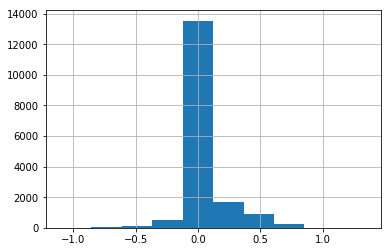

In [27]:
(occurrence_df.shuffled_entropy - occurrence_df.sim_shuffled_entropy).hist()